NEEDED
- reference (here Salmo salar)

PROGRAMS
- bowtie2
- pysam


## External reference

In [66]:
import os.path
import pysam
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

In [4]:
need_ref = True

In [5]:
if need_ref:
    !cp /foraker/genomes/ref_genomes/Ssa_ASM_3.6/Ssa_ASM_3.6.fasta /home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta

In [7]:
salmo_FASTA = '/home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta'

build bowtie2 index
 - printed because this take ~2 hours to run

In [9]:
print('bowtie2-build -r {} salmo'.format(salmo_FASTA))

bowtie2-build -r /home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta salmo


## internal reference

In [10]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

## Align

In [11]:
SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.SAM'
filtered_SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.SAM'

In [12]:
print('bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Data/salmo/salmo -U {} -S {}'.format(chum_ref, SAM_output))

bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Data/salmo/salmo -U /media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta -S /home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.SAM


## Examine alignments

### Reference genome (Salmo salar)

In [13]:
ref = pysam.FastaFile(salmo_FASTA)

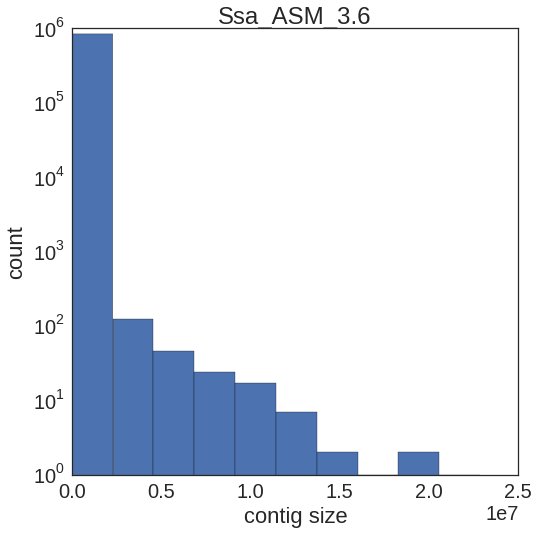

In [14]:
figsize(8,8)
plt.hist([ln for ln in ref.lengths])
plt.yscale('log', basey=10)
plt.ylabel('count')
plt.xlabel('contig size')
plt.title('Ssa_ASM_3.6')
plt.show()

#### Alignments to salmo

    

In [15]:
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

In [16]:
mpqs = [read.mapping_quality for read in get_aligns()]

Looks like we have three types of alignments (tri-modal)
    - spurious (MQ < 2)
    - moderate support (10 < MQ < 28)
    - strong support (MQ > 30)

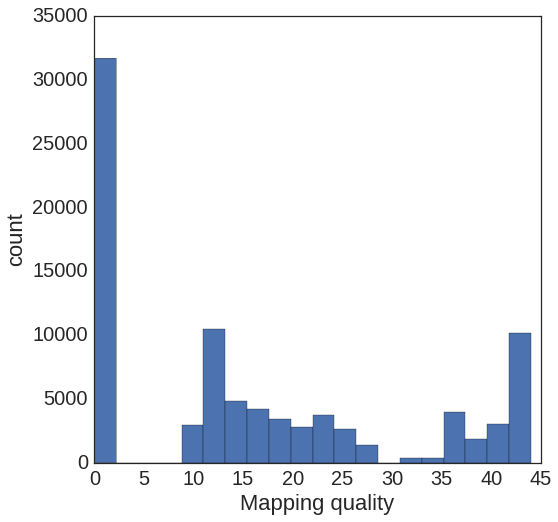

In [17]:
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

In [18]:
flags  = [read.flag for read in get_aligns()]

#### Flags 
* 4 = unmapped
* 16 = mapped to reverse strand

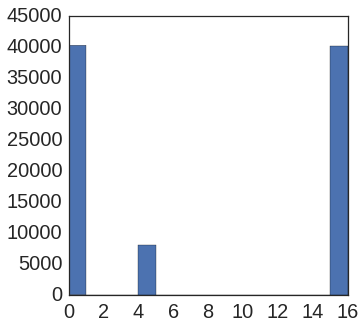

In [19]:
figsize(5,5)
plt.hist(flags, bins = 16)
plt.show()

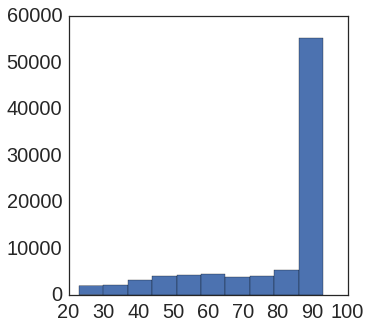

In [20]:
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.show()

#### Distribution of edit distances
held by tag 'XM'

In [21]:
edit_ditances = list()
mq = list()
for read in get_aligns():
    try:
        edit_ditances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

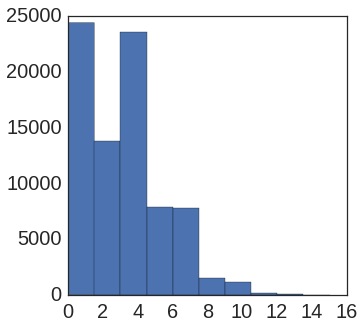

In [22]:
plt.hist(edit_ditances)
plt.show()

Edit distance does not tell the whole story. 
Low edit distances (<5) result in a braod range of mapping qualities.

In [23]:
rr = pd.DataFrame({'ed' : edit_ditances, 'mq' : mq })

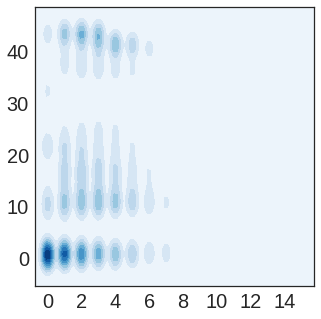

In [24]:
sns.kdeplot(rr, cmap="Blues", shade = True, legend = True)
plt.show()

#### Lets keep only the alignments with:
(query_alignment_length == 93) AND (mapping_quality >= 30)

In [25]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 93) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

Which contigs are getting alignments?

#### convert SAM to BAM, sort and index BAM

In [26]:
BAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.BAM'
sorted_BAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.sorted.BAM'

In [27]:
!samtools view -bh {filtered_SAM_output} > {BAM_output}
!samtools sort -O bam -T temp {BAM_output} > {sorted_BAM_output}
!samtools index  {sorted_BAM_output}

In [28]:
!samtools idxstats {sorted_BAM_output} > \
'/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.coverage'

In [29]:
cov = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.coverage',
           sep = "\t", header = None)
cov.columns = ['contig', 'len', 'COV', 'UNK']
cov.head()

,contig,len,COV,UNK
0,ccf1000001392_0-0,45142,0,0
1,ccf1000000113_0-0,1375438,2,0
2,ccf1000001220_0-0,71750,0,0
3,ccf1000001280_0-0,62617,0,0
4,ccf1000000663_0-0,188506,0,0


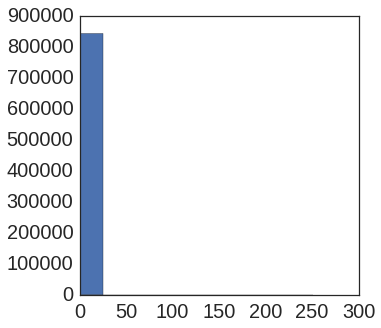

In [30]:
plt.hist(cov['COV'])

plt.show()

In [31]:
filtered_SAM = pd.read_csv(filtered_SAM_output, sep = '\t', comment='@', engine='python', 
            names = ['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','ISIZE','SEQ','QUAL',
                     'TAG1', 'TAG2', 'TAG3' 'TAG4', 'TAG5', 'TAG6', 'TAG7','TAG8', 'TAG9','TAG10'])
filtered_SAM.head()

,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,ISIZE,SEQ,QUAL,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c3,0,jcf1000092099_0-0,10553614,42,93M,*,0,0,TGCAGGATTCATAGGAGAAAAACAAGGCTTCATGTCAGTTTGACCC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:154,XN:i:0,XM:i:4,XO:i:0,XG:i:0,NM:i:4,MD:Z:8G11C6G9A55,YT:Z:UU,None
1,c6,16,ccf1000000032_0-0,4350808,41,93M,*,0,0,AGTAACTTCACGGCCTCCTCCCCAGGGCTCGTTCAACTTCCAGGGC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:138,XN:i:0,XM:i:6,XO:i:0,XG:i:0,NM:i:6,MD:Z:12C16T5T4T0G9G41,YT:Z:UU,None
2,c9,0,jcf1000020280_0-0,135823,42,63M1D30M,*,0,0,TGCAGGAAACTGGGGAAATTATTTTCAACACCTTGTGATTAGTCCA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:146,XN:i:0,XM:i:4,XO:i:1,XG:i:1,NM:i:5,MD:Z:10C3A10G37^G8G21,YT:Z:UU,None
3,c10,16,jcf1001213740_0-0,1121507,44,93M,*,0,0,TGAACGCGCTGTGAACTCCAGAGATGCCCTCGCCAAGCAGATCTAT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:6G9G64T11,YT:Z:UU,None
4,c28,0,jcf1000298869_0-0,2793545,44,93M,*,0,0,TGCAGGCAAAGATGAAAAATAACACTACCACTACTGCTCAGTGTCT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:27G24A8T31,YT:Z:UU,None


In [32]:
filtered_aligns = filtered_SAM[['QNAME','RNAME', 'POS']]
filtered_aligns.head()

,QNAME,RNAME,POS
0,c3,jcf1000092099_0-0,10553614
1,c6,ccf1000000032_0-0,4350808
2,c9,jcf1000020280_0-0,135823
3,c10,jcf1001213740_0-0,1121507
4,c28,jcf1000298869_0-0,2793545


In [34]:
linkage_map = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/linkage_map/LEPmap/with_paralogs/final/PS_chum_map_2015.txt', sep = '\t')
linkage_map.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM
0,c4311,4311,28282,28282_88,4584,1,0,1,0
1,c4311,4311,28282,28282_91,4584,1,0,1,0
2,c56875,56875,39970,39970_17,7377,1,0,1,0
3,c56875,56875,39970,39970_33,7377,1,0,1,0
4,c56875,56875,39970,39970_49,7377,1,0,1,0


In [36]:
chum_LGs = pd.merge(linkage_map, filtered_aligns, left_on = 'contig', right_on ='QNAME')
chum_LGs.drop_duplicates(subset=['contig'], inplace=True)
chum_LGs.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM,QNAME,RNAME,POS
0,c2167,2167,10293,10293_9,1923,1,0.00,1,0.00,c2167,ccf1000001037_0-0,11464
2,c60695,60695,43220,43220_70,8274,1,0.00,1,0.00,c60695,jcf1000011812_0-0,968377
3,c46019,46019,30764,30764_8,5153,1,0.00,1,0.00,c46019,ccf1000000672_0-0,113879
4,c51260,51260,35231,35231_66,6171,1,0.00,1,0.00,c51260,jcf1000011812_0-0,134630
5,c25202,25202,13251,13251_91,2346,1,0.99,1,0.99,c25202,jcf1000413715_0-0,846430


#### ots_salmo.txt is a file that lists the chromosome assignment for a small subset of the scaffolds

In [37]:
ots_salmo = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/ots_salmo.txt', 
            sep = '\t', header = 0)
ots_salmo.head()

,Linkage Group,Ssa Genome Scaffold,Map Start (cM),Map End (cM),Scaffold Start (bp),Scaffold End (bp),Map Distance (bp),Scaffold Distance (bp),bp/cM,Loci Aligned,Orientation,Ssa Chromosomal Assignment
0,Ots01,jcf1000732633_0-0,4.71,4.71,256226,1164421,0.00,908195,NaN,3,NaN,Ssa23
1,Ots01,jcf1000298869_0-0,4.71,18.71,1055825,9091671,14.00,8035846,"573,989.00",21,-,Ssa23
2,Ots01,ccf1000000015_0-0,18.71,35.83,148475,8257101,17.12,8108626,"473,634.70",19,+,Ssa23
3,Ots01,ccf1000000022_0-0,36.14,54.50,296511,6626313,18.36,6329802,"344,760.46",17,-,NOT FOUND
4,Ots01,jcf1001138103_0-0,55.05,55.05,1134693,1931119,0.00,796426,NaN,3,NaN,Ssa23


In [38]:
salmo_chr = ots_salmo[['Ssa Genome Scaffold', 'Ssa Chromosomal Assignment']]
salmo_chr.columns = ['scaffold', 'Ssa_chr']
salmo_chr.head()

,scaffold,Ssa_chr
0,jcf1000732633_0-0,Ssa23
1,jcf1000298869_0-0,Ssa23
2,ccf1000000015_0-0,Ssa23
3,ccf1000000022_0-0,NOT FOUND
4,jcf1001138103_0-0,Ssa23


#### Merging them based on Ssa scaffolds allows us to compare Chum LGs with Ssa chromosomes

In [39]:
chum_ssa = pd.merge(chum_LGs,salmo_chr, left_on='RNAME', right_on='scaffold')
chum_ssa.drop_duplicates(subset='stacks_SNP', inplace = True)
#print(len(chum_ssa))
chum_ssa.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM,QNAME,RNAME,POS,scaffold,Ssa_chr
0,c25202,25202,13251,13251_91,2346,1,0.99,1,0.99,c25202,jcf1000413715_0-0,846430,jcf1000413715_0-0,Ssa09
1,c64062,64062,46054,46054_32,8970,1,1.46,1,1.46,c64062,ccf1000000035_0-0,683768,ccf1000000035_0-0,Ssa09
2,c55627,55627,38917,38917_64,7124,1,1.46,1,1.46,c55627,ccf1000000035_0-0,1454905,ccf1000000035_0-0,Ssa09
3,c37517,37517,23631,23631_32,3764,1,2.95,1,2.95,c37517,ccf1000000035_0-0,2548177,ccf1000000035_0-0,Ssa09
4,c73997,73997,54135,54135_73,10673,1,3.37,1,3.37,c73997,ccf1000000035_0-0,3632581,ccf1000000035_0-0,Ssa09


In [40]:
LG_vs_CHR = pd.crosstab(chum_ssa['LEP_LG'], columns = chum_ssa['Ssa_chr'])
LG_vs_CHR.index.name = 'Chum LG - LEPmap'

In [54]:
#chum_ssa['Ssa_chr']

In [69]:
synteny_summary = chum_ssa[['contig', 'paper1_LG', 'cM', 'RNAME', 'Ssa_chr']].copy()
synteny_summary.rename(columns = {'paper1_LG':'chum_LG', 'cM':'chum_cM'}, inplace=True)
synteny_summary['Ssa_chr'] = [int(xx.split('a')[1]) if 'Ssa' in xx else 40 for xx in synteny_summary['Ssa_chr']]
synteny_summary.head()

,contig,chum_LG,chum_cM,RNAME,Ssa_chr
0,c25202,1,0.99,jcf1000413715_0-0,9
1,c64062,1,1.46,ccf1000000035_0-0,9
2,c55627,1,1.46,ccf1000000035_0-0,9
3,c37517,1,2.95,ccf1000000035_0-0,9
4,c73997,1,3.37,ccf1000000035_0-0,9


In [70]:
xx = synteny_summary.sort(columns = ['chum_LG', 'chum_cM']).copy()
xx['chum_pos'] = [ee for ee in range(len(xx))]
xx = xx.sort(columns = ['Ssa_chr'])


yy = synteny_summary.sort(columns = ['Ssa_chr']).copy()
xx['Ots_pos'] = [ee for ee in range(len(yy))]

In [71]:
xx_breaks = np.where(np.diff(xx.sort(columns = ['chum_LG', 'chum_cM'])['chum_LG'])==1)
yy_breaks = np.where(np.diff(xx.sort(columns = ['Ssa_chr'])['Ssa_chr'])==1)

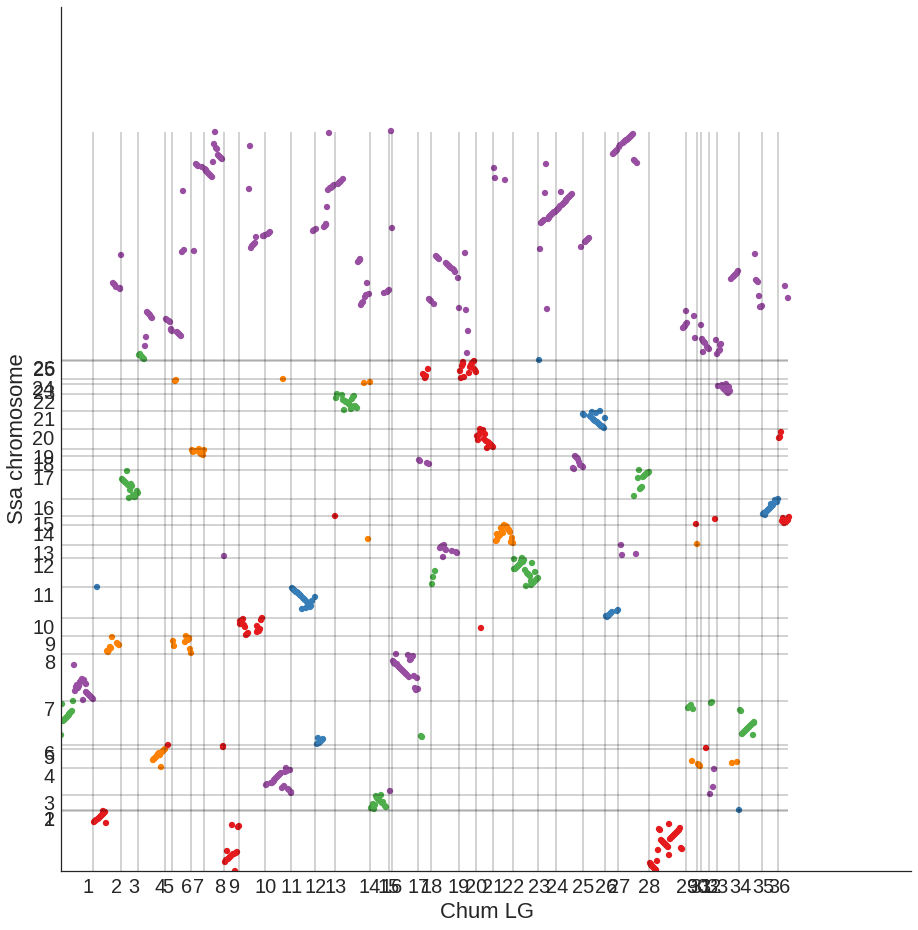

In [72]:
sns.lmplot('chum_pos', 'Ots_pos', data = xx, fit_reg = False, hue = 'Ssa_chr', legend = False,
           palette=sns.color_palette("Set1", 5), size = 13, scatter_kws = {'alpha':1, 's':40})
plt.xlim(0); plt.ylim(0)
np.diff(xx.sort(columns = ['chum_LG', 'chum_cM'])['chum_LG'])
plt.vlines(xx_breaks, ymin = 0, ymax = 770, alpha = .2)
plt.hlines(yy_breaks, xmin = 0, xmax = 770, alpha = .2)
plt.xticks([x-10 for x in xx_breaks[0]], range(1,38), horizontalalignment = 'left')
plt.yticks([x-10 for x in yy_breaks[0]], range(1,38))
plt.xlabel('Chum LG')
plt.ylabel('Ssa chromosome')
plt.show()

#### Number of alignments from Chum to Atlantic salmon
Notice no matches to:
    - Ssa08

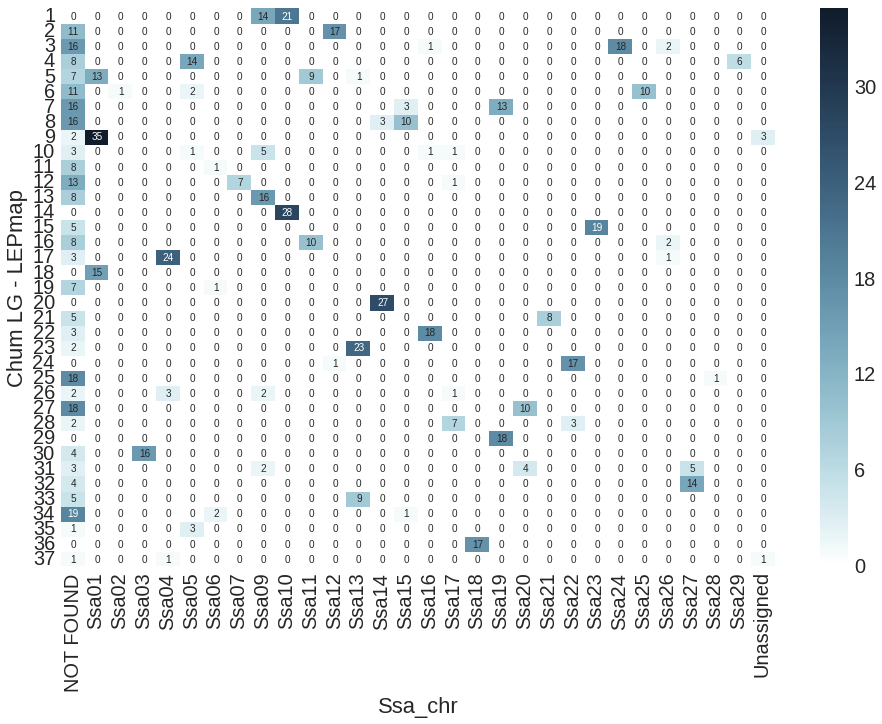

In [41]:
figsize(16,10)
my_colors = sns.cubehelix_palette(n_colors = 6, light=1, start = 2.8, rot = -.1, gamma = 1.2, as_cmap=True)
sns.heatmap(LG_vs_CHR, annot = True, linewidths = 0,square = False, cmap=my_colors, 
           cbar_kws={"orientation": "vertical"})
plt.show()

In [42]:
chum_ssa.to_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/chum_ssa.txt',sep = '\t')

In [43]:
chum_ssa.groupby('LEP_LG')['Ssa_chr'].count()

LEP_LG
1     35
2     28
3     37
4     28
5     30
6     24
7     32
8     29
9     40
10    11
11     9
12    21
13    24
14    28
15    24
16    20
17    28
18    15
19     8
20    27
21    13
22    21
23    25
24    18
25    19
26     8
27    28
28    12
29    18
30    20
31    14
32    18
33    14
34    22
35     4
36    17
37     3
Name: Ssa_chr, dtype: int64

In [44]:
chum_ssa.groupby('Ssa_chr')['LEP_LG'].count()

Ssa_chr
NOT FOUND     229
Ssa01          63
Ssa02           1
Ssa03          16
Ssa04          28
Ssa05          20
Ssa06           4
Ssa07           7
Ssa09          39
Ssa10          49
Ssa11          19
Ssa12          18
Ssa13          33
Ssa14          30
Ssa15          14
Ssa16          20
Ssa17          10
Ssa18          17
Ssa19          31
Ssa20          14
Ssa21           8
Ssa22          20
Ssa23          19
Ssa24          18
Ssa25          10
Ssa26           5
Ssa27          19
Ssa28           1
Ssa29           6
Unassigned      4
Name: LEP_LG, dtype: int64

#### Ssa chromosome assignments of the Ssa scaffolds that recieved at least one alignment

In [45]:
ssa_cov.groupby('Ssa_chr')['contig'].nunique()

NameError: name 'ssa_cov' is not defined

#### Number of RAD loci aligning to scaffolds placed on each chromosome

In [46]:
ssa_cov.groupby('Ssa_chr')['COV'].sum()

NameError: name 'ssa_cov' is not defined

#### As expected, larger genome scaffolds have more RAD loci aligned to them

In [47]:
sns.jointplot('len', 'COV', data = ssa_cov,  kind = 'reg', size = 8, 
              xlim =(-1, max(ssa_cov['len'])), ylim=(-1, max(ssa_cov['COV'])))
plt.show()

NameError: name 'ssa_cov' is not defined